In [65]:
# General
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import datetime

#import sklearn
import sklearn
from sklearn import *

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

import graphviz
import xgboost

import warnings
warnings.filterwarnings('ignore')

In [66]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [67]:
#Let us load the transactions from the 2018-08-25 to the 2018-09-14, and plot the number of transactions per day, fraudulent transactions per day, and fraudulent cards per day.

# Load data from the 2018-08-25 to the 2018-09-14

DIR_INPUT='./simulated-data-transformed/data/' 

BEGIN_DATE = "2018-08-25"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
Wall time: 228 ms
201141 transactions loaded, containing 1835 fraudulent transactions


In [68]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,1399512,2018-08-25 00:00:23,4381,4218,7.00,12614423,146,0,0,1,...,13.0,7.719231,71.0,9.425070,0.0,0.0,3.0,0.0,19.0,0.0
1,1399513,2018-08-25 00:00:41,1780,2258,31.67,12614441,146,0,0,1,...,4.0,37.465000,25.0,43.452000,0.0,0.0,9.0,0.0,38.0,0.0
2,1399514,2018-08-25 00:00:53,3548,1228,108.45,12614453,146,0,0,1,...,18.0,58.278333,65.0,60.915231,0.0,0.0,4.0,0.0,13.0,0.0
3,1399515,2018-08-25 00:00:54,3864,3305,14.54,12614454,146,0,0,1,...,32.0,23.466875,126.0,21.542063,1.0,0.0,13.0,0.0,41.0,0.0
4,1399516,2018-08-25 00:01:28,655,2113,81.52,12614488,146,0,0,1,...,23.0,105.704348,79.0,113.671013,0.0,0.0,3.0,0.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201136,1600648,2018-09-14 23:56:09,581,1072,44.55,14428569,166,0,0,0,...,15.0,32.692667,62.0,32.186613,1.0,0.0,9.0,0.0,33.0,0.0
201137,1600649,2018-09-14 23:56:17,3343,7549,50.93,14428577,166,0,0,0,...,30.0,100.098667,94.0,91.341383,0.0,0.0,6.0,0.0,32.0,0.0
201138,1600650,2018-09-14 23:56:32,1724,2482,24.12,14428592,166,0,0,0,...,23.0,37.620000,81.0,48.893086,2.0,0.0,7.0,0.0,30.0,0.0
201139,1600651,2018-09-14 23:57:41,760,9688,42.70,14428661,166,0,0,0,...,8.0,81.035000,30.0,81.804333,1.0,0.0,8.0,0.0,36.0,0.0


In [4]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_frauded_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_frauded_cards_per_day":nb_frauded_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

In [5]:
tx_stats.head()

,TX_TIME_DAYS,nb_tx_per_day,nb_fraudulent_transactions_per_day,nb_frauded_cards_per_day,tx_date
0,146,9499,86,73,2018-08-25
1,147,9728,95,89,2018-08-26
2,148,9597,95,82,2018-08-27
3,149,9622,77,65,2018-08-28
4,150,9285,92,84,2018-08-29


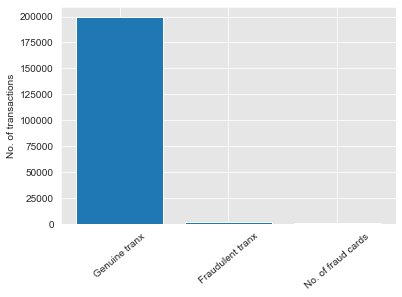

In [6]:
a = np.sum(tx_stats['nb_tx_per_day'])
b = np.sum(tx_stats['nb_fraudulent_transactions_per_day'])
c = a - b
d = np.sum(tx_stats['nb_frauded_cards_per_day'])

header = ['Genuine tranx','Fraudulent tranx', 'No. of fraud cards']

data_eda = pd.DataFrame([c,b,d])
data_eda['name'] = header

plt.bar(data_eda['name'],data_eda[0])
plt.ylabel('No. of transactions')
plt.xticks(rotation=40)
plt.show()

In [63]:
a

201141

In [60]:
b

1835

In [61]:
c

199306

In [62]:
d

1614

In [7]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200), 
        'nb_frauded_cards_per_day':cmap(250)}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-08-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of frauded cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_frauded_cards_per_day'], 'b', color=colors['nb_frauded_cards_per_day'], label = '# fraudulent cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

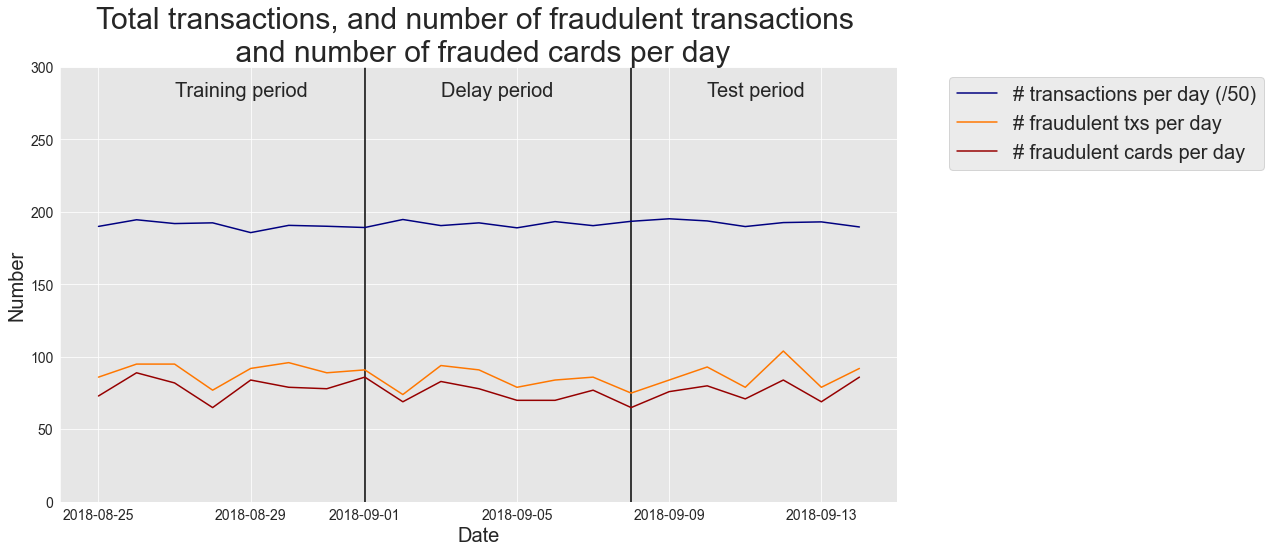

In [8]:
fraud_and_transactions_stats_fig

I have chosen our test set to take place one week after the last transaction of the training set. In a fraud detection context, this period separating the training and test set is referred to as the delay period or feedback delay. 

It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or thanks to the result of a fraud investigation. 

Therefore, in a realistic scenario, the annotated data available to train a model and start making prediction for a given day are anterior to that day minus the delay period. Setting a delay period of one week is simplistic. It assumes that the labels (fraudulent or genuine) for all transactions are known exactly one week after they occurred. 

This is in practice not the case, since the delay may be shorter when customers report frauds quickly, or much longer in cases where frauds remain undetected for months. The delay period is in fact a parameter in the assessment of a fraud detection model. A one-week delay is to a reasonable basis. For simplicity of our baseline model, we will be working on this assumption for the project.

# Model testing

In [9]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be frauded after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known frauded customers from the training set
    known_frauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Frauded cards from that test day, minus the delay period, are added to the pool of known frauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_frauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_frauded_customers = known_frauded_customers.union(new_frauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_frauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [10]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

In a fraud detection context, the goal is to find a function that can predict whether a transaction is fraudulent or genuine (the output feature), using features that characterize the transactions (the input features).

We will define the input and output features as follows:

The output feature will be the transaction label TX_FRAUD

The input features will be the transaction amount TX_AMOUNT, as well as all the features that were computed in the previous section, which characterize the context of a transaction.


In [11]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

In [12]:
#the implementation below for computing these three performance metrics

def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_frauded_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_frauded_cards) / top_k
    
    return list_detected_frauded_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_frauded_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected frauded cards is empty
    list_detected_frauded_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_frauded_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected frauded cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_frauded_cards)==False]
        
        nb_frauded_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_frauded_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected frauded cards
        if remove_detected_frauded_cards:
            list_detected_frauded_cards.extend(detected_frauded_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_frauded_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

We now have all the building blocks to train and assess other classifiers.

Let us train the prediction models: decision tree with depth 2, a decision tree with unlimited depth, a logistic regression model, a random forest, and a boosting model. 

These models are the most commonly used in benchmarks in the fraud detection literature

For this purpose, let us first create a dictionary of sklearn classifiers that instantiates each of these classifiers. 

We then train and compute the predictions for each of these classifiers using the fit_model_and_get_predictions function.

In [13]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [14]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)

In [15]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions

[22:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
# Let us finally assess the prediction performances of these five models, 
# on the test set and the training set, and their execution times.

def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances

In [17]:
# performances on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test', 
                                                        top_k_list=[100])

df_performances.style.background_gradient(subset=['AUC ROC', 'Average precision','Card Precision@100'], cmap='Greens')

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.885000,0.662000,0.324000
Decision tree with depth of two,0.817000,0.595000,0.311000
Decision tree - unlimited depth,0.812000,0.345000,0.287000
Random forest,0.881000,0.705000,0.336000
XGBoost,0.873000,0.707000,0.319000


In [18]:
# performances on training set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, train_df, 
                                                        type_set='train', 
                                                        top_k_list=[100])

df_performances.style.background_gradient(subset=['AUC ROC', 'Average precision','Card Precision@100'], cmap='Blues')

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.897000,0.654000,0.407000
Decision tree with depth of two,0.805000,0.579000,0.396000
Decision tree - unlimited depth,1.000000,1.000000,0.580000
Random forest,1.000000,1.000000,0.580000
XGBoost,1.000000,0.996000,0.579000


In [19]:
def execution_times_model_collection(fitted_models_and_predictions_dictionary):

    execution_times=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        execution_times_model=pd.DataFrame() 
        execution_times_model['Training execution time']=[model_and_predictions['training_execution_time']]
        execution_times_model['Prediction execution time']=[model_and_predictions['prediction_execution_time']]
        execution_times_model.index=[classifier_name]
        
        execution_times=execution_times.append(execution_times_model)
        
    return execution_times

In [20]:
# Execution times
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times.style.background_gradient(subset=['Training execution time', 'Prediction execution time'], cmap='YlGnBu')

,Training execution time,Prediction execution time
Logistic regression,0.178041,0.010001
Decision tree with depth of two,0.114042,0.009002
Decision tree - unlimited depth,1.092951,0.011003
Random forest,1.757396,0.100022
XGBoost,2.709790,0.046010


The main takeaways in these performance results:

-	All prediction models have learned useful fraud patterns from the training data.This can be seen from the AUC ROC on the test set, which is higher than 0.5 for all classifiers, and an average precision much higher than 0.007.

-	The random forest and XGBoost provide better performances (in terms of Average Precision) than logistic regression and decision trees. 

-	The relative performances of the classifiers differ depending on which performance metrics is used. For example, a decision tree of depth 2 has a lower AUC ROC than a decision tree of unlimited depth, but a higher average precision.

-	The performance of some classifiers (Random Forest and Decision Tree with unlimited depth) is perfect on the training set (AUC ROC and Average Precision of 1), but lower on the test set. In fact, the decision tree with unlimited depth is actually the worst classifier on the test set in terms of Average Precision. This is due to overfitting.

-	The execution times for training ensembles of models (Random forest and XGBoost) is significantly higher than decision trees and logistic regression.


Plotting the ROC, AUC and PR curves:

# ROC AUC

In [21]:
def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")

Time to fit the Logistic regression model: 0.37
Time to fit the Decision tree with depth of two model: 0.34
Time to fit the Decision tree - unlimited depth model: 1.33
Time to fit the Random forest model: 2.2
[22:40:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time to fit the XGBoost model: 3.09


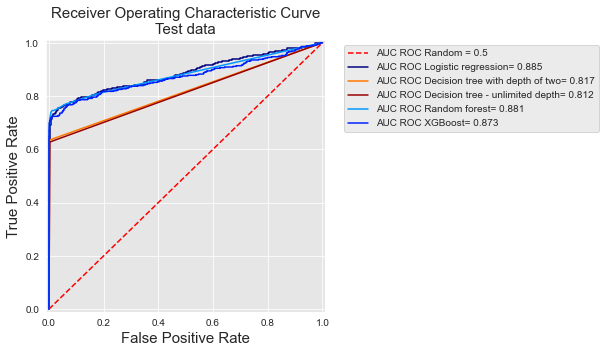

In [22]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    start_time=time.time()
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                          input_features=input_features,
                                                          output_feature=output_feature)
    
    print("Time to fit the "+classifier_name+" model: "+str(round(time.time()-start_time,2)))
    
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions

    

roc_curve, ax = plt.subplots(1, 1, figsize=(5,5))

cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200), 
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40)}

get_template_roc_curve(ax,title='Receiver Operating Characteristic Curve\nTest data',fs=15)
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    FPR_list, TPR_list, threshold = metrics.roc_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    ROC_AUC = metrics.auc(FPR_list, TPR_list)

    ax.plot(FPR_list, TPR_list, 'b', color=colors[classifier_name], label = 'AUC ROC {0}= {1:0.3f}'.format(classifier_name,ROC_AUC))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))



# PR curve

 We will use the Average Precision (AP), which summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.

In [23]:
def compute_AP(precision, recall):
    
    AP = 0
    
    n_thresholds = len(precision)
    
    for i in range(1, n_thresholds):
        
        if recall[i]-recall[i-1]>=0:
            
            AP = AP+(recall[i]-recall[i-1])*precision[i]
        
    return AP

In [24]:
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))

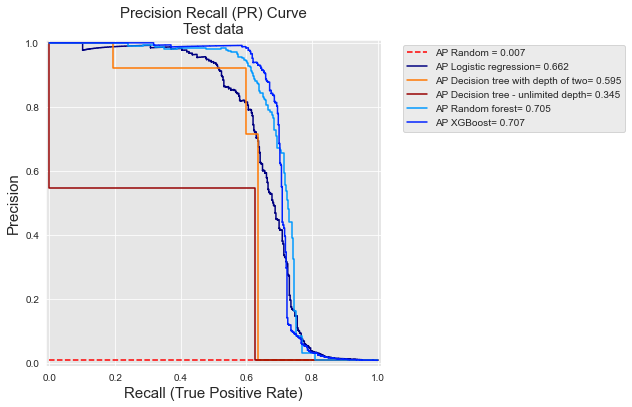

In [25]:
# Let us finally reuse the experimental setting of the previous section, 
# and plot the PR curves and corresponding AP for each of the five prediction models.

pr_curve, ax = plt.subplots(1, 1, figsize=(6,6))
cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200), 
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40)}

get_template_pr_curve(ax, "Precision Recall (PR) Curve\nTest data",fs=15,baseline=sum(test_df[output_feature])/len(test_df[output_feature]))
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    precision, recall, threshold = metrics.precision_recall_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    precision=precision[::-1]
    recall=recall[::-1]
    
    AP = metrics.average_precision_score(test_df[output_feature], model_and_predictions['predictions_test'])
    
    ax.step(recall, precision, 'b', color=colors[classifier_name], label = 'AP {0}= {1:0.3f}'.format(classifier_name,AP))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    
    
plt.subplots_adjust(wspace=0.5, hspace=0.8)

The TPR for low FPR values is actually what matters in a fraud detection problem: The number of cards that can be manually checked by fraud investigators is in practice very limited.

# Validation and Hyperparameter tuning

We will require more data this time for validation. We load three months of transaction data, and define the output feature as the fraud label TX_FRAUD, and the inputs features as the set of features obtained from the baseline preprocessing.

In [26]:
# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-07-11"
END_DATE = "2018-10-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
Wall time: 753 ms
785424 transactions loaded, containing 6983 fraudulent transactions


In [27]:
# The reference starting date for training is set at 2018-08-25, and the deltas to seven days (see Validation Strategies).

# Number of folds for the prequential validation
n_folds=4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-08-25", "%Y-%m-%d")
delta_train=delta_delay=delta_test=delta_valid=delta_assessment=7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

In [28]:
def card_precision_top_k_custom(y_true, y_pred, top_k, transactions_df):
    
    # Let us create a predictions_df DataFrame, that contains all transactions matching the indices of the current fold
    # (indices of the y_true vector)
    predictions_df=transactions_df.iloc[y_true.index.values].copy()
    predictions_df['predictions']=y_pred
    
    # Compute the CP@k using the function implemented in Chapter 4, Section 4.2
    nb_frauded_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k=\
        card_precision_top_k(predictions_df, top_k)
    
    # Return the mean_card_precision_top_k
    return mean_card_precision_top_k

In [29]:
# The performance metrics are the 
# AUC ROC, 
# the average Precision, 
# and the Card Precision@100.

# Only keep columns that are needed as argument to custome scoring function
# to reduce serialisation time of transaction dataset
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

For the sake of conciseness, let us define a model_selection_wrapper function, that will perform prequential validation for both the validation and the test sets.

In [30]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

Prequential validation can now be performed with the few following lines of code, by

- defining which classifier to use

- defining which parameters to test

- fitting the models and assessing the performances

In [31]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision','Card Precision@100']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances_df[metric+' Test'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Test'+' Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
    performances_results.loc["Test performance"]=test_performance

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in ['AUC ROC Test','Average precision Test','Card Precision@100 Test']:
    
        # Find the index which provides the optimal performance
        index_optimal_test_performance = performances_df.index[np.argmax(performances_df[metric].values)]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances_df[parameter_column_name].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances_df[metric].iloc[index_optimal_test_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    performances_results.loc["Optimal parameters"]=optimal_parameters
    performances_results.loc["Optimal test performance"]=optimal_test_performance
    
    return performances_results

# Decision tree classifier

In [32]:
def prequentialSplit(transactions_df,
                     start_date_training, 
                     n_folds=4, 
                     delta_train=7,
                     delta_delay=7,
                     delta_assessment=7):
    
    prequential_split_indices=[]
        
    # For each fold
    for fold in range(n_folds):
        
        # Shift back start date for training by the fold index times the assessment period (delta_assessment)
        # (See Fig. 5)
        start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test (assessment) sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train=list(train_df.index)
        indices_test=list(test_df.index)
        
        prequential_split_indices.append((indices_train,indices_test))
    
    return prequential_split_indices

In [33]:
def prequential_grid_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):
    
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=grid_search.cv_results_['params']
    performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']
    
    return performances_df

In [34]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df

In [35]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,4,4,4
Validation performance,0.807+/-0.01,0.593+/-0.02,0.278+/-0.01
Test performance,0.82+/-0.03,0.621+/-0.08,0.309+/-0.03
Optimal parameters,4,4,4
Optimal test performance,0.82+/-0.03,0.621+/-0.08,0.309+/-0.03


# Logistic regression

In [36]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,100], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [37]:
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1,1,0.1
Validation performance,0.867+/-0.01,0.627+/-0.02,0.292+/-0.01
Test performance,0.883+/-0.02,0.636+/-0.04,0.315+/-0.02
Optimal parameters,0.1,0.1,0.1
Optimal test performance,0.883+/-0.02,0.641+/-0.05,0.315+/-0.02


# Random Forest

In [38]:
%%time

classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df

Wall time: 9min 44s


In [39]:
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/10,100/20,100/20
Validation performance,0.874+/-0.02,0.68+/-0.01,0.299+/-0.01
Test performance,0.88+/-0.02,0.695+/-0.06,0.329+/-0.03
Optimal parameters,100/20,100/20,100/20
Optimal test performance,0.883+/-0.02,0.695+/-0.06,0.329+/-0.03


The best performances are obtained with forests containing 100 trees, with a maximum depth of 10 or 20.

The optimal parameters differ from the best estimated parameters for the AUC and CP@100.

The difference in terms of performances is however low, and the best estimated parameters can be considered close to the optimal ones.

Fixing the number of trees to 100, we get:

In [40]:
# Get the performance plot for a single performance metric
def get_performance_plot(performances_df, 
                         ax, 
                         performance_metric, 
                         expe_type_list=['Test','Train'], 
                         expe_type_color_list=['#008000','#2F4D7E'],
                         parameter_name="Tree maximum depth",
                         summary_performances=None):
    
    # expe_type_list is the list of type of experiments, typically containing 'Test', 'Train', or 'Valid'
    # For all types of experiments
    for i in range(len(expe_type_list)):
    
        # Column in performances_df for which to retrieve the data 
        performance_metric_expe_type=performance_metric+' '+expe_type_list[i]
    
        # Plot data on graph
        ax.plot(performances_df['Parameters summary'], performances_df[performance_metric_expe_type], 
                color=expe_type_color_list[i], label = expe_type_list[i])
        
        # If performances_df contains confidence intervals, add them to the graph
        if performance_metric_expe_type+' Std' in performances_df.columns:
        
            conf_min = performances_df[performance_metric_expe_type]\
                        -2*performances_df[performance_metric_expe_type+' Std']
            conf_max = performances_df[performance_metric_expe_type]\
                        +2*performances_df[performance_metric_expe_type+' Std']
    
            ax.fill_between(performances_df['Parameters summary'], conf_min, conf_max, color=expe_type_color_list[i], alpha=.1)

    # If summary_performances table is present, adds vertical dashed bar for best estimated parameter 
    if summary_performances is not None:
        best_estimated_parameter=summary_performances[performance_metric][['Best estimated parameters']].values[0]
        best_estimated_performance=float(summary_performances[performance_metric][['Validation performance']].values[0].split("+/-")[0])
        ymin, ymax = ax.get_ylim()
        ax.vlines(best_estimated_parameter, ymin, best_estimated_performance,
                  linestyles="dashed")
    
    # Set title, and x and y axes labels
    ax.set_title(performance_metric+'\n', fontsize=14)
    ax.set(xlabel = parameter_name, ylabel=performance_metric)

In [41]:
# Get the performance plots for a set of performance metric
def get_performances_plots(performances_df, 
                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                           expe_type_list=['Test','Train'], expe_type_color_list=['#008000','#2F4D7E'],
                           parameter_name="Tree maximum depth",
                           summary_performances=None):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_performance_plot(performances_df, ax[i], performance_metric=performance_metrics_list[i], 
                             expe_type_list=expe_type_list, 
                             expe_type_color_list=expe_type_color_list,
                             parameter_name=parameter_name,
                             summary_performances=summary_performances)
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=expe_type_list, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Type set")

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

In [42]:
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")

summary_performances_fixed_number_of_trees

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/10,100/20,100/20
Validation performance,0.874+/-0.02,0.68+/-0.01,0.299+/-0.01
Test performance,0.88+/-0.02,0.695+/-0.06,0.329+/-0.03
Optimal parameters,100/20,100/20,100/20
Optimal test performance,0.883+/-0.02,0.695+/-0.06,0.329+/-0.03


A maximum tree depth of 5 provides the lowest peformances. 

Performances increase with maximum tree depth, until a tree depth of 10 to 20 where they reach a plateau then slightly decrease.

Fixing the maximum tree depth to 20, we get:

In [43]:
performances_df_rf_fixed_max_tree_depth=performances_df_rf[performances_df_rf["Parameters summary"].str.endswith("20")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_rf_fixed_max_tree_depth, parameter_column_name="Parameters summary")

summary_performances_fixed_max_tree_depth

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/20,100/20,100/20
Validation performance,0.866+/-0.02,0.68+/-0.01,0.299+/-0.01
Test performance,0.883+/-0.02,0.695+/-0.06,0.329+/-0.03
Optimal parameters,100/20,100/20,100/20
Optimal test performance,0.883+/-0.02,0.695+/-0.06,0.329+/-0.03


It is worth noting that the execution times for training random forests linearly increases with the number of trees. This can be illustrated by plotting the execution times as a function of the number of trees.

In [44]:
# Get the performance plot for a single performance metric
def get_execution_times_plot(performances_df,
                             title="",
                             parameter_name="Tree maximum depth"):
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    
    # Plot data on graph
    ax.plot(performances_df['Parameters summary'], performances_df["Execution time"], 
            color="black")
        
    # Set title, and x and y axes labels
    ax.set_title(title, fontsize=14)
    ax.set(xlabel = parameter_name, ylabel="Execution time (seconds)")

In [45]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_rf,2))+"s")

Total execution time for the model selection procedure: 584.95s


# XGBoost

In [46]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[2,3,5], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.05, 0.1],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost for model performance comparison at the end of this notebook
performances_df_xgboost=performances_df

In [47]:
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/3,100/0.1/3,100/0.1/3
Validation performance,0.872+/-0.02,0.691+/-0.01,0.301+/-0.01
Test performance,0.878+/-0.02,0.707+/-0.05,0.328+/-0.03
Optimal parameters,100/0.1/3,100/0.1/3,100/0.1/3
Optimal test performance,0.878+/-0.02,0.707+/-0.05,0.328+/-0.03


The best parameters obtained by validation are the same for ROC AUC, and slightly differ for the average precision. The corresponding test performances are however on par.

Let us plot the performances as a function of the maximum tree depth, for a number of trees set to 100. Increasing the maximum tree depth does not clearly affect the performances. It slightly increases performances for AUC ROC and AP.

In [48]:
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.1")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")

summary_performances_fixed_number_of_trees

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/3,100/0.1/3,100/0.1/3
Validation performance,0.872+/-0.02,0.691+/-0.01,0.301+/-0.01
Test performance,0.878+/-0.02,0.707+/-0.05,0.328+/-0.03
Optimal parameters,100/0.1/3,100/0.1/3,100/0.1/3
Optimal test performance,0.878+/-0.02,0.707+/-0.05,0.328+/-0.03


Let us then plot the performances as a function of the number of trees, for a maximum tree depth set to 5.

In [49]:
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.1/5")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")

summary_performances_fixed_max_tree_depth

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50/0.1/5,100/0.1/5,100/0.1/5
Validation performance,0.872+/-0.02,0.687+/-0.01,0.299+/-0.01
Test performance,0.874+/-0.02,0.702+/-0.05,0.326+/-0.02
Optimal parameters,100/0.1/5,100/0.1/5,100/0.1/5
Optimal test performance,0.878+/-0.02,0.702+/-0.05,0.326+/-0.02


Similar to random forests, increasing the maximum tree depth and the number of trees comes at a cost in terms of execution times. This is illustrated in the two figures below.

In [50]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_boosting,2))+"s")

Total execution time for the model selection procedure: 492.13s


# Comparison of model performances

Let us compare these performances in order to determine which model class provides the best performances.

For each model class, let us retrieve the performance for three types of parameters:

- Default parameters: Default parameters that sklearn gives to a model class. The default parameters for each model class are:

    - Decision tree: max_depth=None.

    - Logistic regression: C=1.

    - Random forest: n_estimators=100, max_depth=None.

    - XGBoost: n_estimators=100, max_depth=2, learning_rate=0.1.

- Best estimated parameters: Parameters that provide the highest performances on the validation set.

- Optimal parameters: Parameters that provide the highest performances on the test set.

In [51]:
performances_df_dictionary={
    "Decision Tree": performances_df_dt,
    "Logstic Regression": performances_df_lr,
    "Random Forest": performances_df_rf,
    "XGBoost": performances_df_xgboost
}

In [52]:
def model_selection_performances(performances_df_dictionary,
                                 performance_metric='AUC ROC'):
    
    # Note: max_depth of 50 is similar to None
    default_parameters_dictionary={
        "Decision Tree": 50,
        "Logstic Regression": 1,
        "Random Forest": "100/50",
        "XGBoost": "100/0.1/2"
    }
    
    mean_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    std_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    # For each model class
    for model_class, performances_df in performances_df_dictionary.items():
        
        # Get the performances for the default paramaters
        default_performances=performances_df[performances_df['Parameters summary']==default_parameters_dictionary[model_class]]
        default_performances=default_performances.round(decimals=3)
        
        mean_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test"].values[0])
        std_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test Std"].values[0])
        
        # Get the performances for the best estimated parameters
        performances_summary=get_summary_performances(performances_df, parameter_column_name="Parameters summary")
        mean_std_performances=performances_summary.loc[["Test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[1]))
        
        # Get the performances for the boptimal parameters
        mean_std_performances=performances_summary.loc[["Optimal test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[1]))
        
    # Return the mean performances and their standard deviations    
    return (mean_performances_dictionary,std_performances_dictionary)

In [53]:
# For examples, executing the function for the AUC ROC metric returns:

model_selection_performances(performances_df_dictionary,
                             performance_metric='AUC ROC')

({'Default parameters': [0.816, 0.883, 0.878, 0.875],
  'Best validation parameters': [0.82, 0.883, 0.88, 0.878],
  'Optimal parameters': [0.82, 0.883, 0.883, 0.878]},
 {'Default parameters': [0.034, 0.023, 0.019, 0.015],
  'Best validation parameters': [0.03, 0.02, 0.02, 0.02],
  'Optimal parameters': [0.03, 0.02, 0.02, 0.02]})

For better visualization, let us plot the performances for the four model classes and for each performance metric as bar charts. The implementation is provided with the get_model_selection_performance_plot and get_model_selection_performances_plots below.

In [54]:
# Get the performance plot for a single performance metric
def get_model_selection_performance_plot(performances_df_dictionary, 
                                         ax, 
                                         performance_metric,
                                         ylim=[0,1]
                                        ):
    
    
    (mean_performances_dictionary,std_performances_dictionary) = \
        model_selection_performances(performances_df_dictionary=performances_df_dictionary,
                                     performance_metric=performance_metric)
    
    
    model_classes=list(performances_df_dictionary.keys())
    
    # width of the bars
    barWidth = 0.3
    # The x position of bars
    r1 = np.arange(len(model_classes))
    r2 = r1+barWidth
    r3 = r1+2*barWidth
    
    # Create Default parameters bars (Orange)
    ax.bar(r1, mean_performances_dictionary['Default parameters'], 
           width = barWidth, color = '#CA8035', edgecolor = 'black', 
           yerr=std_performances_dictionary['Default parameters'], capsize=7, label='Default parameters')
 
    # Create Best validation parameters bars (Red)
    ax.bar(r2, mean_performances_dictionary['Best validation parameters'], 
           width = barWidth, color = '#008000', edgecolor = 'black', 
           yerr=std_performances_dictionary['Best validation parameters'], capsize=7, label='Best validation parameters')

    # Create Optimal parameters bars (Green)
    ax.bar(r3, mean_performances_dictionary['Optimal parameters'], 
           width = barWidth, color = '#2F4D7E', edgecolor = 'black', 
           yerr=std_performances_dictionary['Optimal parameters'], capsize=7, label='Optimal parameters')
 

    # Set title, and x and y axes labels
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xticks(r2+barWidth/2)
    ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
    ax.set_title(performance_metric+'\n', fontsize=18)
    ax.set_xlabel("Model class", fontsize=16)
    ax.set_ylabel(performance_metric, fontsize=15)

In [55]:
def get_model_selection_performances_plots(performances_df_dictionary, 
                                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    parameter_types=['Default parameters','Best validation parameters','Optimal parameters']
    
    ylim_list=[[0.6,0.9],[0.2,0.8],[0.2,0.35]]
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_model_selection_performance_plot(performances_df_dictionary, 
                                             ax[i], 
                                             performance_metrics_list[i],
                                             ylim=ylim_list[i]
                                            )
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=parameter_types, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Parameter type",
                                       prop={'size': 12},
                                       title_fontsize=12)

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

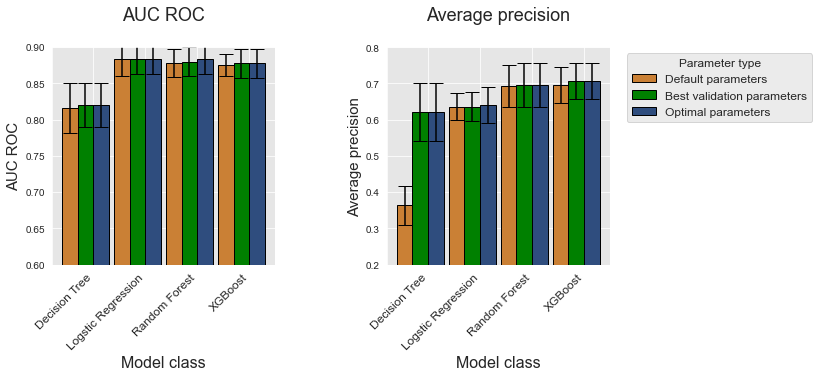

In [56]:
get_model_selection_performances_plots(performances_df_dictionary, 
                                       performance_metrics_list=['AUC ROC', 'Average precision'])
    

On this simulated dataset, XGBoost provides the highest performances, followed by random forest, logistic regression, and finally decision trees which have the lowest performances.

The gap in terms of performance is most visible with the average precision metric.

The performances of logistic regression, random forest, and XGBoost are very similar in terms of AUC ROC.

In [57]:
# Let us plot the total execution times of the model selection procedure for each model class.
execution_times=[execution_time_dt,execution_time_lr,
                 execution_time_rf,execution_time_boosting]

In [58]:
%%capture

fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))

model_classes=list(performances_df_dictionary.keys())
    
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(model_classes))
    
# Create execution times bars
ax.bar(r1, execution_times, 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)

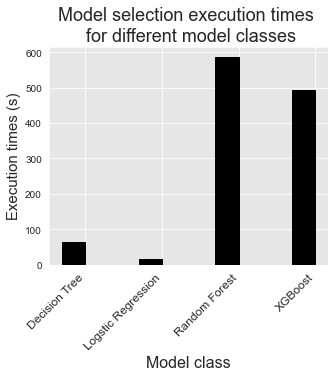

In [59]:
fig_model_selection_execution_times_for_each_model_class

The comparison in terms of execution times is mostly qualitative since they depend to a large extent on the number of parameter combinations that were considered in the model selection procedure. 

It however illustrates that model selection for complex models such as random forests or boosting usually requires more computational resources, since they require tuning a higher number of hyperparameters.